In [5]:
import time 
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from numpy.core import shape_base
from numpy.core.fromnumeric import shape
from Integration_methods_bodies import Leapfrog_step
from test_constants import CoM_pos, CoM_vel, angular_momentum, total_energy, kinetic_energy
from ode_function import ode_func

Plots the fill_matrix for a given successful perturbation simulation.

In [6]:
################################ Setup ################################ 
######## CHANGE VALUES BELOW ########
# Setup values
# Approx 16 orbits per 100 time units
duration = 1000 # time units, not seconds
dt = 0.001 # Not needed if CFL stepping, but needs to be declared

## Courant number
C = 0.1

# Energy error threshold
e_thresh = 0.05
box_size = 10
timestep_size = 10e-4

# Gravitational constant
G = 1
#G = 6.67408e-11

# Visualisation
#vis_type = 'graph'
#dims = 2
#plot_more = True
######## CHANGE VALUES ABOVE ########

In [7]:
def perturb_fig_8(v_x_perturbation = 0,v_y_perturbation = 0,plot_more = False):
    '''
    Runs the simulation with a perturbation to initial conditions
    Defaults to no perturbation
    '''
    # Fig 8
    mass = (1,1,1) # Equal masses
    x_IC_x = 0.97000436
    x_IC_y = 0.24308753
    v_IC_x = -0.93240737
    v_IC_y = -0.86473146
    x_ICs = (x_IC_x,-x_IC_y,0,-x_IC_x,x_IC_y,0,0,0,0) # x,y,z,x,y,z,...
    v_ICs = (-v_IC_x/2,-v_IC_y/2,0,-v_IC_x/2,-v_IC_y/2,0,v_IC_x,v_IC_y,0) # x,y,z,x,y,z,...
    x_ICs = np.asarray(x_ICs)
    v_ICs = np.asarray(v_ICs)
    ###### Perturb the v_ICs
    v_perturb_x = v_IC_x+v_x_perturbation
    v_perturb_y = v_IC_y+v_y_perturbation
    v_ICs = (-v_perturb_x/2,-v_perturb_y/2,0,-v_perturb_x/2,-v_perturb_y/2,0,v_perturb_x,v_perturb_y,0) # x,y,z,x,y,z,...
    ###### Perturb the x_ICs
    m = 1
    B = 5/2 * G * m**2
    D = 3/4 * m
    R = np.sqrt(x_IC_x**2 + x_IC_y**2)
    R_hat = B/((B/R) + D*(2*v_x_perturbation*v_IC_x + 2*v_y_perturbation*v_IC_y + v_x_perturbation**2 + v_y_perturbation**2))
    theta = np.arctan(np.abs(x_IC_y)/np.abs(x_IC_x))
    x_perturb_x = np.abs(R_hat*np.cos(theta))
    x_perturb_y = np.abs(R_hat*np.sin(theta))
    x_ICs = (x_perturb_x,-x_perturb_y,0,-x_perturb_x,x_perturb_y,0,0,0,0) # x,y,z,x,y,z,..


    n_bodies = round(len(x_ICs)/3)

    # Check number of bodies is consistent
    if len(x_ICs) != len(v_ICs) or len(x_ICs) != len(mass)*3:
        raise Exception('Position and velocity IC vectors must both have 3 times the length of the masses vector')

    x_array = np.empty((3*n_bodies,1))
    v_array = np.empty((3*n_bodies,1))
    x_array[:,0] = np.transpose(x_ICs)
    v_array[:,0] = np.transpose(v_ICs)

    ##  Tracking 'conserved' quantities, and reset to CoM frame
    # CoM position
    CoM = np.empty((3,1))
    CoM[:,0] = CoM_pos(x_array[:,0],mass) # Initial CoM
    # CoM velocity
    CoM_v = np.empty((3,1))
    CoM_v[:,0] = CoM_vel(v_array[:,0],mass) # Initial CoM

    # In centre of mass frame
    CoM_pos_array = np.tile(CoM,(n_bodies,1))
    x_array[:,0] = x_array[:,0] - CoM_pos_array[:,0]
    CoM_vel_array = np.tile(CoM_v,(n_bodies,1))
    v_array[:,0] = v_array[:,0] - CoM_vel_array[:,0]

    # Angular momentum
    L = np.empty((3,1))
    L[:,0] = angular_momentum(x_array[:,0],v_array[:,0],mass) # Initial angular momentum
    # Energy
    E = np.empty(1)
    E[0],r = total_energy(x_array[:,0],v_array[:,0],mass,G) # Initial energy

    ## These are similar to above, except for just CFL values
    ## dt_CFL_prog is for plotting over time
    dt_CFL_prog = np.empty(1)
    dt_CFL_prog[0] = 0
    ## dt_CFL_store is storing each dt
    dt_CFL_store= []

    ################################ Run method ################################
    #t0 = time.time()
    i = -1
    while dt_CFL_prog[-1] < duration:
        i += 1
        #### Step forward
        ## Finding CFL dt values
        del_t = np.ones((n_bodies,n_bodies))
        for j in range(n_bodies):
            for k in range(j+1,n_bodies):
                if r[j,k] != 0:
                    del_t[j,k] = (C * r[j,k])/np.linalg.norm(v_array[3*j:(j+1)*3,i] - v_array[3*k:(k+1)*3,i])
                else:
                    del_t[j,k] = np.max(del_t)
                del_t[k,j] = del_t[j,k]
        dt_CFL_0 = np.min(del_t)
        dt = dt_CFL_0 # Actual timestep to be used
        # Update position and velocity 
        x_array_test,v_array_test = Leapfrog_step(x_array[:,i],v_array[:,i],ode_func,dt,mass,G)

        #Calculate energy to get r
        _,r_1 = total_energy(x_array_test,v_array_test,mass,G)
        #### Recalculate dt at future timestep
        ## Finding CFL dt values
        del_t = np.ones((n_bodies,n_bodies))
        for j in range(n_bodies):
            for k in range(j+1,n_bodies):
                if r_1[j,k] != 0:
                    del_t[j,k] = (C * r_1[j,k])/np.linalg.norm(v_array_test[3*j:(j+1)*3] - v_array_test[3*k:(k+1)*3])
                else:
                    del_t[j,k] = np.max(del_t)
                del_t[k,j] = del_t[j,k]

        dt_CFL_1 = np.min(del_t) # Current variable timestep
        # Calculate timestep to use
        dt_CFL = (1/2) * (dt_CFL_0 + dt_CFL_1)
        # Store and use this dt_CFL
        dt_CFL_prog = np.append(dt_CFL_prog,dt_CFL_prog[i] + dt_CFL) # This is cumulative vector of dt
        dt_CFL_store = np.append(dt_CFL_store,dt_CFL) # This stores dt at each time
        dt = dt_CFL
        # Update position and velocity 
        x_array_hold,v_array_hold = Leapfrog_step(x_array[:,i],v_array[:,i],ode_func,dt,mass,G)
        x_array = np.append(x_array,np.reshape(np.asarray(x_array_hold),(-1,1)),axis=1)
        v_array = np.append(v_array,np.reshape(np.asarray(v_array_hold),(-1,1)),axis=1)
        ## Track conserved quantities
        L = np.append(L,np.reshape(np.asarray(angular_momentum(x_array[:,i+1],v_array[:,i+1],mass)),(-1,1)),axis=1)
        E_hold,r = total_energy(x_array[:,i+1],v_array[:,i+1],mass,G)
        E = np.append(E,E_hold)
        ## Stop if position or energy error grows too large
        final_it = i+1 # Final iteration
        if np.mod(i,100) == 0:
            # Every 100 steps, check
            if any(np.abs(x_array[:,i+1]) > box_size):
                # If position goes outside square/cube of side length 2*box_size, centred on origin
                print('Outside box of size {}, so terminated at time {}'.format(box_size,dt_CFL_prog[i+1]))
                failure_class = 1
                return failure_class, x_array

            elif np.abs((E[i+1] - E[0])/E[0]) > e_thresh:
                # If energy error goes above the threshold
                print('Rel energy error is above {}, so terminated at time {}'.format(e_thresh,dt_CFL_prog[i+1]))
                failure_class = 2
                return failure_class, x_array

            elif dt < timestep_size:
                # If timestep size goes below the threshold
                print('Timestep size is below {}, so terminated at time {}'.format(timestep_size,dt_CFL_prog[i+1]))
                failure_class = 3
                return failure_class, x_array

    #t1 = time.time() - t0    
    #print('Real time for computation: {} seconds'.format(t1))

       
    ################################ Visualise ################################
    #visualise(x_array,mass,'animation',2) 
    # Want this false for grid search simulations
    if plot_more:
        t_axis = dt_CFL_prog[:final_it+1]
        ### Trajectory
        fig = plt.figure()
        fig.set_size_inches(18.5, 10.5)
        gs = fig.add_gridspec(2, 2)
        # x,y plane
        ax0 = fig.add_subplot(gs[0, :])
        ax0.set_title('x-y plane')
        elements = np.arange(start = 0,stop = (n_bodies)*3,step = 3).astype(int)
        ax0.plot(np.transpose(x_array[elements,:final_it+1]),np.transpose(x_array[elements+1,:final_it+1]))
        ax0.set_xlabel('x')
        ax0.set_ylabel('y')
        labels = list(map(str,mass))
        ax0.legend(labels,title = 'Masses of bodies')
        # x and y against t
        ax1 = fig.add_subplot(gs[1, :-1])
        ax1.set_title('x against t')
        for i in range(n_bodies):
            ax1.plot(t_axis,x_array[i*3,:final_it+1])
        ax1.set_xlabel('time')
        ax1.set_ylabel('x')
        #
        ax2 = fig.add_subplot(gs[1:, -1])
        ax2.set_title('y against t')
        for i in range(n_bodies):
            ax2.plot(t_axis,x_array[(i*3) + 1,:final_it+1])
        ax2.set_xlabel('time')
        ax2.set_ylabel('y')
        fig.tight_layout()
        plt.show()

        # Plot delta t
        fig, ax = plt.subplots()
        fig.set_size_inches(18.5, 10.5)
        ax.plot(np.arange(final_it),dt_CFL_store[:final_it])
        plt.xlabel('steps')
        plt.ylabel('dt')
        plt.title('Plot of dt chosen for each timestep, with C = {}'.format(C))
        plt.show()


        # Plot energy over time
        E = E[:final_it+1]
        if E[0] != 0:
            print('E0 not 0')
            energy_error = np.abs((E - E[0])/E[0])
        else:
            print('E0 is 0')
            energy_error = np.abs(E - E[0])/np.sum(kinetic_energy(v_array[:,0],mass))
        fig, ax = plt.subplots()
        fig.set_size_inches(18.5, 10.5)    
        ax.plot(t_axis,energy_error)
        plt.xlabel('time')
        plt.ylabel('energy error')
        plt.title('Relative error of energy against time')
        plt.show()

        # Plot L_z over time
        L = L[:,:final_it+1] 
        if L[2,0] != 0:
            print('Lz0 not 0')
            L_z_error = (L[2,:] - L[2,0])/L[2,0]
        else:
            print('Lz0 is 0')
            x_0 = (x_array[:,0].reshape((3,-1),order = 'F'))
            v_0 = (v_array[:,0].reshape((3,-1),order = 'F'))
            CoM = CoM_pos(x_array[:,0],mass).reshape((3,-1))
            p_0 = v_0*mass[0] # Momentum
            r_0 = x_0 - CoM # All r vectors
            L_0 = np.cross(r_0[:,0],p_0[:,0])
            L_z_error = (L[2,:] - L[2,0])/L_0[2]
                
        fig, ax = plt.subplots()
        fig.set_size_inches(18.5, 10.5)    
        ax.plot(t_axis,L_z_error)
        plt.xlabel('time')
        plt.ylabel('L_z error')
        plt.title('Relative error of angular momentum (z) against time')
        plt.show()

    failure_class = 0  #If it reaches the end, it stays as a fig-8
    print('Ran for full duration (finish time: {})'.format(dt_CFL_prog[final_it]))
    return failure_class, x_array

In [4]:
gridsearch = False
if gridsearch:
    square_size_x = 0.5
    square_size_y = 0.2
    num_of_points_x = 6
    num_of_points_y = 3
    perturb_x = np.linspace(-square_size_x,square_size_x,num_of_points_x)
    perturb_y = np.linspace(-square_size_y,square_size_y,num_of_points_y)
    
    failure_class = np.empty((len(perturb_x),len(perturb_y)))
    #E = np.empty((len(perturb_x),len(perturb_y)))
    #L_z = np.empty((len(perturb_x),len(perturb_y)))

    for i in range(len(perturb_x)):
        for j in range(len(perturb_y)):
            failure_class[i,j],x_array = perturb_fig_8(v_x_perturbation = perturb_x[i],v_y_perturbation = perturb_y[j],plot_more = False)
            print(perturb_x[i],perturb_y[j],failure_class[i,j])
    print('Perturbation 1 = {}'.format(perturb_x))
    print('Perturbation 2 = {}'.format(perturb_y))
    print('Key:')
    print('0 = completed','\n','1 = outside box','\n','2 = energy error','\n','3 = timestep error')
    #print('failure_class = {}'.format(failure_class))
    #print('Energy = {}'.format(E))
    #print('Ang mom = {}'.format(L_z))

    #### Plot reason for failure
    fig, ax = plt.subplots()
    ax.axis('equal')
    heatmap = ax.pcolormesh(perturb_x,perturb_y,np.transpose(failure_class),shading='nearest',cmap=plt.cm.get_cmap('Dark2', 4))
    cbar = plt.colorbar(heatmap)
    #legend
    cbar.ax.get_yaxis().set_ticks([])
    for j, lab in enumerate(['Complete','Position','Energy','Timestep']):
        cbar.ax.text(6, (4 * j + 2) / 8.0, lab, ha='center', va='center')
    # put the major ticks at the middle of each cell
    ax.set_xticks(perturb_x, minor=False)
    plt.xticks(rotation = 90)
    ax.set_yticks(perturb_y, minor=False)
    plt.xlabel('Perturbation of x component of centre particle velocity') 
    plt.ylabel('Perturbation of y component of centre particle velocity')
    plt.show()

else:
    # Single perturbation, for testing
    v_x_perturbation = 1 #-0.575
    v_y_perturbation = -0.13333333 #0.1625
    plot_more = False
    _,x_array = perturb_fig_8(v_x_perturbation,v_y_perturbation,plot_more)
    print('Key:')
    print('0 = completed','\n','1 = outside box','\n','2 = energy error','\n','3 = timestep error')

<ipython-input-3-028dc6f10eb8>:82: RuntimeWarning: divide by zero encountered in double_scalars
  del_t[j,k] = (C * r[j,k])/np.linalg.norm(v_array[3*j:(j+1)*3,i] - v_array[3*k:(k+1)*3,i])


Ran for full duration (finish time: 1000.0303554588579)
Key:
0 = completed 
 1 = outside box 
 2 = energy error 
 3 = timestep error


In [9]:
print(x_array[:3,:].shape)

(3, 26431)


In [26]:
r1 = x_array[:3,:]
r2 = x_array[3:6,:]
r3 = x_array[6:,:]
R1 = r1 - r2
R2 = r2 - r3
R3 = r1 - r2
N = np.linalg.norm(R1,axis = 0) + np.linalg.norm(R2,axis = 0) + np.linalg.norm(R3,axis = 0)
X1 = R1/N
X2 = R2/N
X3 = R3/N
X1_norm = np.linalg.norm(X1,axis = 0)
X2_norm = np.linalg.norm(X2,axis = 0)
X3_norm = np.linalg.norm(X3,axis = 0)
# These sum to 1 for all time

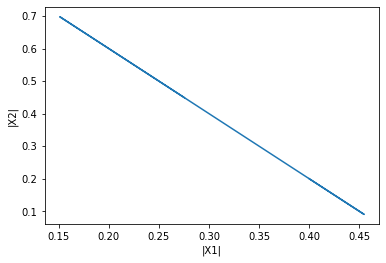

In [27]:
plt.plot(X1_norm,X2_norm)
plt.xlabel('|X1|')
plt.ylabel('|X2|')
plt.show()

In [28]:
fill_matrix = np.zeros((1000,1000))
X1_round = np.rint(X1_norm*1000).astype(int)
X2_round = np.rint(X2_norm*1000).astype(int)
for i in range(len(X1_round)):
    fill_matrix[X1_round[i],X2_round[i]] = 1
print(fill_matrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


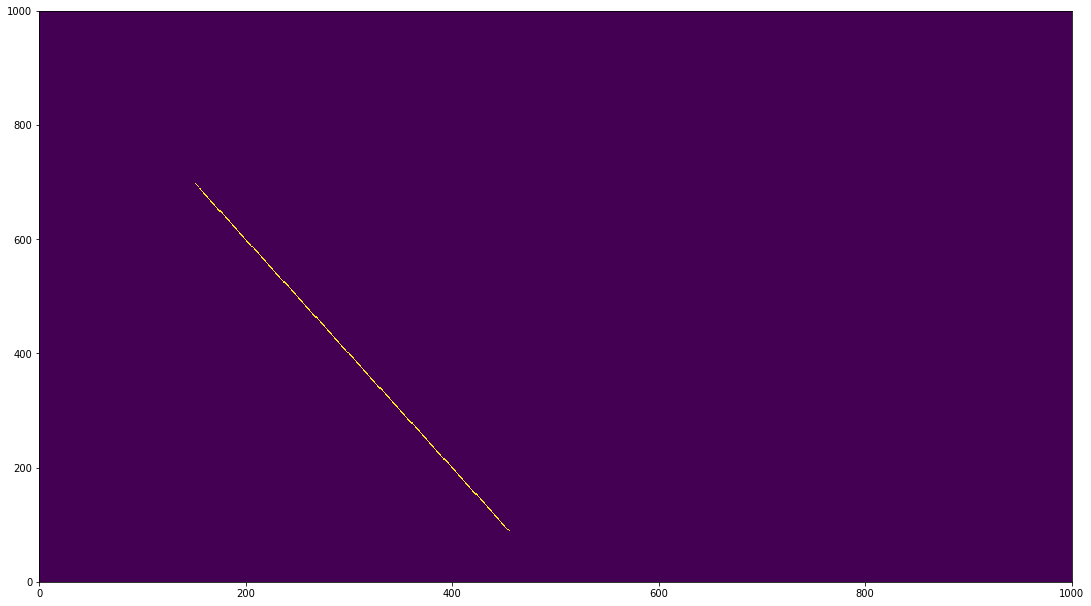

In [31]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.pcolormesh(np.transpose(fill_matrix))
plt.show()

In [30]:
print(np.sum(fill_matrix))

906.0
